## La interfaz general de pipeline

La clase Pipeline no está restringida a preprocesamiento y clasificación, sino que de hecho puede unir cualquier número de estimadores. Por ejemplo, se puede crear un pipeline conteniendo extracción de características, selección de características, escalado y clasificación, para un total de cuatro pasos. Del mismo modo, el último paso podría ser regresión o clustering en lugar de la clasificación.

El único requisito para los estimadores en un pipeline es que todos menos el último paso necesitan tener un método `transform`, de manera que  puedan producir una nueva representación de los datos que se pueden usar en el próximo paso.

Internamente, durante la llamada a `Pipeline.fit`, pipeline llama a `fit`  y luego  a `transform` en cada paso, con la entrada dada por la salida del método de `transform` del paso anterior. Para el último paso, solo se llama a `fit`.

Este proceso es ilustrado en la siguiente figura para los transformadores $T1$ y $T2$ y un clasificador llamado `Classifier`:

![](Grafico7.png)


Un pipeline es en realidad aún más general que esto. No es necesario que el último paso de un pipeline tenga una función `predict` y podríamos crear un pipeline que contenga, por ejemplo, un escalador y un PCA. Entonces, dado que el último paso (PCA) tiene un método `transform`, podríamos llamar a `transform` en el pipeline para obtener la salida de `PCA.transform` aplicada a los datos que se procesaron en el paso anterior. El último paso de un pipeline solo es necesario para tener un método `fit`.

### Conveniente creación de Pipeline con make_pipeline

Crear un pipeline utilizando la sintaxis descrita anteriormente es a veces un poco engorroso y a menudo no necesitamos nombres especificados por el usuario para cada paso. Hay una función conveniente llamada `make_pipeline`, que  creará un pipeline y nombrará automáticamente cada paso en función de su clase. La sintaxis para make_pipeline es la siguiente:

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline

# sintaxis estandar
pipe_1 = Pipeline([("escalador", MinMaxScaler()), ("svm", SVC(C=100))])
# sintaxis abreviada
pipe_2 = make_pipeline(MinMaxScaler(), SVC(C=100))

Los objetos pipeline `pipe_1` y `pipe_2` hacen exactamente lo mismo, pero `pipe_2` tiene pasos que se nombraron automáticamente. Podemos ver los nombres de estos  pasos con el atributo `steps`:

In [6]:
print("Pasos pipeline:\n{}".format(pipe_2.steps))

Pasos pipeline:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


Los pasos se denominan `minmaxscaler` y `svc`. En general, los nombres de los pasos son solo versiones en minúsculas de los nombres de las clases. Si varios pasos tienen la misma clase, se agrega un número:

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("Pasos pipeline:\n{}".format(pipe.steps))

Pasos pipeline:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


Como puede ver, el primer paso de `StandardScaler` se llamó `standardscaler-1` y el segundo `standardscaler-2`. Sin embargo, en dichos entornos, podría ser mejor utilizar la construcción de Pipeline con nombres explícitos, para dar más nombres semánticos a cada paso.

### Accediendo  a los atributos de  los  pasos

Con frecuencia, se deseará inspeccionar los atributos de uno de los pasos del pipeline, es decir, los coeficientes de un modelo lineal o los componentes extraídos por PCA. La forma más fácil de acceder a los pasos en un pipeline es a través del atributo `named_steps`, que es un diccionario desde los nombres de los pasos hasta los estimadores:


In [8]:
# fijamos el pipeline al conjunto de datos cancer
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
pipe.fit(cancer.data)

# extraemos los dos principales componentes desde el paso pca
componentes = pipe.named_steps["pca"].components_
print("Dimension de los componentes: {}".format(componentes.shape))

Dimension de los componentes: (2, 30)


### Accediendo a los atributos en un pipeline  de búsqueda grid

Una de las principales razones para usar pipeline es para realizar búsquedas grid. Una tarea común es acceder a algunos de los pasos de un pipeline dentro de una búsqueda grid. Vamos a buscar en un grid, un clasificador LogisticRegression en el conjunto de datos de cáncer, utilizando Pipeline y StandardScaler para escalar los datos antes de pasarlos al clasificador LogisticRegression. Primero creamos un pipeline utilizando la función make_pipeline:

In [9]:
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(StandardScaler(), LogisticRegression())

A continuación, creamos parámetros grid. El parámetro de regularización para ajustar un LogisticRegression es el parámetro C. Usamos logaritmos grid para este parámetro, buscando entre 0.01 y 100. Como usamos la función make_pipeline, el nombre del paso LogisticRegression en el pipeline es el nombre de la clase en minúscula, logisticregression. Para ajustar el parámetro C, tenemos que especificar parámetros grid para logisticregression__C:


In [10]:
parametros_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

Como de costumbre, dividimos el conjunto de datos de cáncer en conjuntos de entrenamiento y prueba y ajustamos una búsqueda grid:

In [14]:
from sklearn.model_selection import GridSearchCV
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, parametros_grid, cv=5)
grid.fit(X_entrenamiento, y_entrenamiento)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Entonces, ¿cómo accedemos a los coeficientes del mejor modelo LogisticRegression que encontró GridSearchCV? Se sabe que el mejor modelo encontrado por GridSearchCV, entrenado en todos los datos de entrenamiento, se almacena en grid.best_estimator_:

In [15]:
print("Mejor estimador:\n{}".format(grid.best_estimator_))

Mejor estimador:
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


Este best_estimator_ en nuestro caso es un pipeline con dos pasos, standardscaler y logisticregression. Para acceder al paso de logisticregression, podemos usar el atributo named_steps del pipeline como se explicó anteriormente:

In [16]:
print("Paso Logistic regression :\n{}".format(
grid.best_estimator_.named_steps["logisticregression"]))

Paso Logistic regression :
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Ahora que tenemos la instancia de LogisticRegression entrenada, podemos acceder a los coeficientes (pesos) asociados con cada característica de entrada:

In [17]:
print("Coeficientes de regresion logistica:\n{}".format( grid.best_estimator_.named_steps["logisticregression"].coef_))

Coeficientes de regresion logistica:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.12293451 -0.38827425 -0.4169485  -0.32533663 -0.13926972]]


Esta podría ser una expresión algo larga, pero a menudo resulta útil en el entendimiento de tus modelos.

### Pasos de preprocesamiento de búsqueda grid y parámetros del modelo

Usando pipelines, podemos encapsular todos los pasos de procesamiento en nuestro flujo de trabajo de machine learning en un solo estimador scikit-learn. Otro beneficio de hacer esto es que ahora podemos ajustar los parámetros del preprocesamiento usando el resultado de una tarea supervisada, como una regresión o una clasificación. En otros cuadernos anteriores, utilizamos funciones polinomiales en el conjunto de datos de Boston antes de aplicar el regresor Ridge. Vamos a modelar ese caso usando un pipeline. El pipeline  contiene tres pasos: escalado de datos, cálculo de características polinómicas y regresión Ridge:

In [20]:
from sklearn.linear_model import Ridge
from sklearn.datasets import load_boston
boston = load_boston()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline( StandardScaler(),PolynomialFeatures(),Ridge())

¿Cómo sabemos qué grados de polinomios elegir, o si elegir algún polinomio o interacción de alguna manera? Idealmente, queremos seleccionar el parámetro `degree` en función del resultado de la clasificación. Usando un pipeline, podemos buscar este parámetro junto con el parámetro `alpha` de Ridge. Para hacer esto, definimos un `parametros_grid` que contiene ambos, apropiadamente prefijados por los nombres de los pasos:

In [30]:
parametros_grid = {'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

Ahora podemos ejecutar nuestra búsqueda grid de nuevo:

In [31]:
grid = GridSearchCV(pipe, param_grid=parametros_grid, cv=5, n_jobs=-1)
grid.fit(X_entrenamiento, y_entrenamiento)

GridSearchCV(cv=5, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'polynomialfeatures__degree': [1, 2, 3], 'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Podemos visualizar el resultado de la validación cruzada usando un mapa de calor:

In [32]:
def mapa_calor(valores, xetiqueta, yetiqueta, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # dibuja los puntajes mediosde validación cruzada
    img = ax.pcolor(valores, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xetiqueta)
    ax.set_ylabel(yetiqueta)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, valor in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % valor, color=c, ha="center", va="center")
    return img

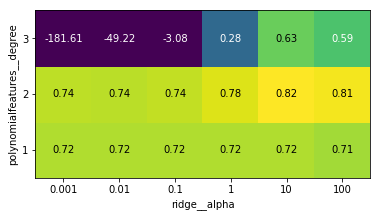

In [33]:
mapa_calor(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xetiqueta="ridge__alpha", yetiqueta="polynomialfeatures__degree",
                      xticklabels=parametros_grid['ridge__alpha'],
                      yticklabels=parametros_grid['polynomialfeatures__degree'], vmin=0)

Al observar los resultados producidos por la validación cruzada, podemos ver que el uso de polinomios de grado dos ayuda, pero que los polinomios de grado tres son mucho peores que los de grado uno o dos. Esto se refleja en los mejores parámetros que se encontraron:

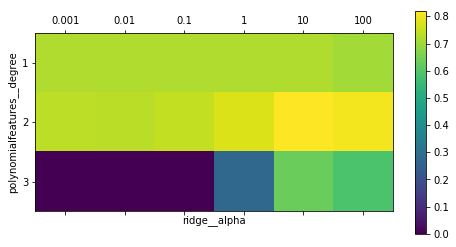

In [36]:
plt.matshow(grid.cv_results_['mean_test_score'].reshape(3, -1),
vmin=0, cmap="viridis")
plt.xlabel("ridge__alpha")
plt.ylabel("polynomialfeatures__degree")
plt.xticks(range(len(parametros_grid['ridge__alpha'])), parametros_grid['ridge__alpha'])
plt.yticks(range(len(parametros_grid['polynomialfeatures__degree'])),
parametros_grid['polynomialfeatures__degree'])
plt.colorbar()

In [37]:
print("Mejores parametros: {}".format(grid.best_params_))

Mejores parametros: {'polynomialfeatures__degree': 2, 'ridge__alpha': 10}


Lo que conduce a la siguiente puntuación:

In [39]:
print("Puntuacion del conjunto de prueba: {:.2f}".format(grid.score(X_prueba, y_prueba)))

Puntuacion del conjunto de prueba: 0.77


Vamos a ejecutar una búsqueda grid sin funciones polinomiales para comparar:


In [40]:
parametros_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, parametros_grid, cv=5)
grid.fit(X_entrenamiento, y_entrenamiento)
print("Puntuacion sin caracteristicas polinomiales: {:.2f}".format(grid.score(X_prueba, y_prueba)))

Puntuacion sin caracteristicas polinomiales: 0.63


Como cabría esperar al observar los resultados de la búsqueda grid visualizados en la figura anterior, el no uso de características polinomiales conduce a resultados  peores.

La búsqueda de los parámetros de preprocesamiento junto con los parámetros del modelo es una estrategia muy poderosa. Sin embargo, tenga en cuenta que GridSearchCV prueba todas las combinaciones posibles de los parámetros especificados. Por lo tanto, agregar más parámetros al grid aumenta exponencialmente la cantidad de modelos que se deben construir.

### ¿Qué modelo usar para la búsqueda grid?

Incluso se puede ir más allá al combinar GridSearchCV y Pipeline: también es posible buscar los pasos reales que se están realizando en el pipeline (digamos si se debe usar StandardScaler o MinMaxScaler). Esto conduce a un espacio de búsqueda aún mayor y debe considerarse cuidadosamente. Probar todas las soluciones posibles generalmente no es una estrategia viable en machine learning.

Sin embargo, aquí hay un ejemplo que compara un clasificador RandomForest y un SVC en el dataset de iris. Sabemos que el SVC podría necesitar que los datos se escalen, por lo que también buscamos si usar StandardScaler o no preprocesamiento. Para el RandomForestClassifier, sabemos que no es necesario un preprocesamiento. Comenzamos definiendo un pipeline. Aquí, nombramos explícitamente los pasos. Queremos dos pasos, uno para el preprocesamiento y luego un clasificador. Podemos instanciar esto usando SVC y StandardScaler:

In [54]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

Ahora podemos definir los `parametros_grid` a buscar. Queremos que el clasificador sea RandomForestClassifier o SVC. Debido a que tienen diferentes parámetros para ajustar y necesitan un preprocesamiento diferente, podemos hacer uso de una lista de  búsqueda grid. Para asignar un estimador a un paso, usamos el nombre del paso como el nombre del parámetro. Cuando queremos omitir un paso en el pipeline (por ejemplo, porque no necesitamos preprocesamiento para el RandomForest), podemos establecer ese paso como `None`:

In [55]:
from sklearn.ensemble import RandomForestClassifier
parametros_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
    'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
    'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

Ahora podemos instanciar y ejecutar la búsqueda grid como de costumbre, aquí en el conjunto de datos `cancer`:

In [57]:
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(
    cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, parametros_grid, cv=5)
grid.fit(X_entrenamiento, y_entrenamiento)

print("Mejores paramétros:\n{}\n".format(grid.best_params_))
print("Mejor puntuación de validación cruzada: {:.2f}".format(grid.best_score_))
print("Puntuacion del conjunto de pruebas: {:.2f}".format(grid.score(X_prueba, y_prueba)))

Mejores paramétros:
{'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 10, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

Mejor puntuación de validación cruzada: 0.99
Puntuacion del conjunto de pruebas: 0.98


El resultado de la búsqueda grid es que un SVC con un preprocesamiento de StandardScaler, `C = 10` y `gamma = 0.01` dió el mejor resultado.